In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

In [4]:
# Parameters
n = 30 # dimension of actions and/or cost matrix
d = 500 # number of initial sample pairs
total_samples = 10000 # number of total samples that can be used
alpha = 0.01 # learning rate for when performing gradient descent on b

In [5]:
# Define what you want R to be
# R = np.identity(n) # identity matrix
R = generate_diagonally_dominant_positive_definite_matrix(n)
R = torch.tensor(R, dtype=torch.float32)

In [6]:
# Initialize b to all 2.0s
b = torch.tensor([2.0]*n, requires_grad=True)

In [7]:
# Initialize D to be empty
D = []

In [8]:
def generate_diagonally_dominant_positive_definite_matrix(size):
    np.random.seed(42)
    A = np.random.rand(size, size)
    A = A + np.diag(np.sum(np.abs(A), axis=1) + 1)
    A = (A + A.T)/2
    return A

In [9]:
# Cost (reward) function a transpose R a
def reward(a, R):
    return torch.matmul(torch.matmul(a.T,R), a)

In [10]:
# generate a random action given the target parameter b s.t. a = b + N(0,1) (make sure a has entries only [-2,2])
def generate_action(b):
    a = b + torch.normal(0,1,(n,))
    return torch.clamp(a, -2, 2)

In [11]:
# Function for gradient clipping
def clip_gradients(theta, max_norm):
    torch.nn.utils.clip_grad_norm_(theta, max_norm)

In [12]:
# Defining simple MLP for Q where we can change the number of layers and the number of neurons in each layer
class Q_theta(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Q_theta, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

    def loss(self, minibatch):
        loss = 0.0
        for a,r in minibatch:
            loss += (self.forward(a) - r)**2
        loss = loss/len(minibatch)
        return loss

# Initialize Q_theta
Q = Q_theta(n, 1, 64)

In [13]:
optimizer = optim.Adam(Q.parameters(), lr=0.01)

In [14]:
# Function to update the parameters of Q with one step of gradient descent
def update_Q(minibatch, learning_rate, max_norm=None):
    optimizer.zero_grad()  # Reset gradients to zero before backward pass
    loss = Q.loss(minibatch)
    loss.backward(retain_graph=True)  # Perform backpropagation
    if max_norm is not None:
        clip_gradients(Q.parameters(), max_norm=max_norm)  # Gradient clipping

    # Manually update the parameters
    with torch.no_grad():  # Disable gradient tracking to perform manual updates
        for param in Q.parameters():
            param -= learning_rate * param.grad  # Update parameters using gradient descent

In [15]:
# Function to update the parameters of b with one step of gradient descent
def update_b(Q,alpha):
    global b
    # To update b, we need to calculate the gradient w.r.t. to it from the Q network's output (use gradient clipping)
    b_grad = torch.autograd.grad(Q(b.unsqueeze(0)), b, create_graph=True)[0]
    with torch.no_grad():  # Update b without tracking gradients
        b.sub_(alpha * b_grad)
        # # Clip gradients
        # b_grad_norm = b_grad.norm()

    # return the final b
    return b

In [16]:
# Algorithm
def BaseMLP():
    global D, b, R

    zoomcost = {}

    # Generate initial sample pairs
    for i in range(d):
        a = generate_action(b)
        r = reward(a, R)
        D.append((a,r))

    for i in range(total_samples - d):

        # generate a random action
        a = generate_action(b)

        # get the reward
        r = reward(a, R)

        # add the new sample pair to D
        D.append((a,r))

        # sample a minibatch from D
        minibatch = random.sample(D, 32)

        # update Q with one step of gradient descent
        update_Q(minibatch, 0.001, 1.0)

        # update b with one step of gradient descent
        b = update_b(Q, alpha)

        # print thr reward every 1000 iterations
        if i % 500 == 0:
            print("Cost at iteration ", i, " is ", reward(b, R))
            # append the cost to the zoomcost dictionary
            zoomcost[i] = reward(b, R)

    # Return the final cost
    return reward(b, R), zoomcost

In [17]:
costs = []
for iter in range(10):
    global b, D, Q
    # set the seed
    torch.manual_seed(iter)
    np.random.seed(iter)

    # reset the parameters
    b = torch.tensor([2.0]*n, requires_grad=True)
    D = []
    Q = Q_theta(n, 1, 64)

    # run the algorithm
    final_cost, zoomcost = BaseMLP()
    costs.append(final_cost)

/var/folders/22/nrb4t9gx0n9bfqq_y59_73p80000gn/T/ipykernel_30249/2388056880.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  return torch.matmul(torch.matmul(a.T,R), a)


Cost at iteration  0  is  tensor(3665.0601, grad_fn=<DotBackward0>)
Cost at iteration  500  is  tensor(3339.0039, grad_fn=<DotBackward0>)
Cost at iteration  1000  is  tensor(2116.4009, grad_fn=<DotBackward0>)
Cost at iteration  1500  is  tensor(506.9696, grad_fn=<DotBackward0>)
Cost at iteration  2000  is  tensor(333.2790, grad_fn=<DotBackward0>)
Cost at iteration  2500  is  tensor(311.1802, grad_fn=<DotBackward0>)
Cost at iteration  3000  is  tensor(298.4539, grad_fn=<DotBackward0>)
Cost at iteration  3500  is  tensor(309.8719, grad_fn=<DotBackward0>)
Cost at iteration  4000  is  tensor(320.7991, grad_fn=<DotBackward0>)
Cost at iteration  4500  is  tensor(327.7381, grad_fn=<DotBackward0>)
Cost at iteration  5000  is  tensor(331.0113, grad_fn=<DotBackward0>)
Cost at iteration  5500  is  tensor(343.9523, grad_fn=<DotBackward0>)
Cost at iteration  6000  is  tensor(377.9483, grad_fn=<DotBackward0>)
Cost at iteration  6500  is  tensor(438.0234, grad_fn=<DotBackward0>)
Cost at iteration  70

In [18]:
print(costs)
# print the mean cost (they are tensor objects)
print(torch.mean(torch.tensor(costs)))

[tensor(1358.6694, grad_fn=<DotBackward0>), tensor(533.9703, grad_fn=<DotBackward0>), tensor(653.7922, grad_fn=<DotBackward0>), tensor(499.6203, grad_fn=<DotBackward0>), tensor(828.4012, grad_fn=<DotBackward0>), tensor(960.8747, grad_fn=<DotBackward0>), tensor(422.8561, grad_fn=<DotBackward0>), tensor(505.8467, grad_fn=<DotBackward0>), tensor(977.1260, grad_fn=<DotBackward0>), tensor(390.4623, grad_fn=<DotBackward0>)]
tensor(713.1619)


In [19]:
# convert the costs to a numpy array using detach
costs = torch.tensor(costs).detach().numpy()

[1358.6694   533.97034  653.79224  499.6203   828.40125  960.8747
  422.85608  505.84674  977.126    390.46228]


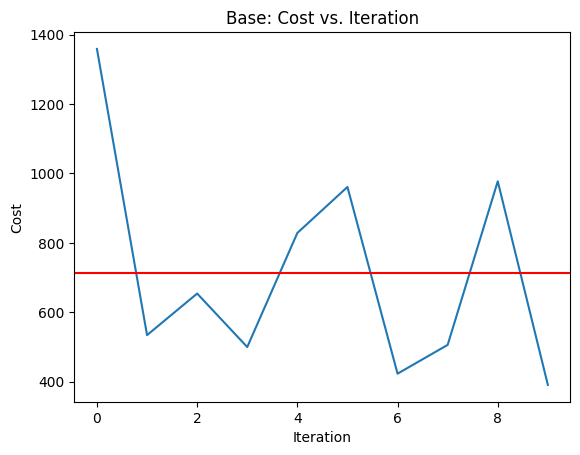

In [27]:
# graph the costs
import matplotlib.pyplot as plt
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Base: Cost vs. Iteration')
# plot the mean cost from the costs in the same graph
mean = costs.mean()
plt.axhline(y=mean, color='r', linestyle='-', label='Mean Cost')

# plt.show()
# save the figure
plt.savefig('Base.png')